In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/raunet_eca_tillepoch_80/pytorch/default/1/best_model.pth
/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/20191026T195815_539_mask.png
/kaggle/input/unetdata/TN_images/TN_images/01580PSFHSAoP4k_1580.png
/kaggle/input/unetdata/test_Masks/test_Masks/00844_PSFHAoP4k_mask.png
/kaggle/input/unetdata/denoised_Standard_plane/Standard_plane/20191115T105730_719.png
/kaggle/input/raunet_eca_tillepoch_150/pytorch/default/1/best_model.pth


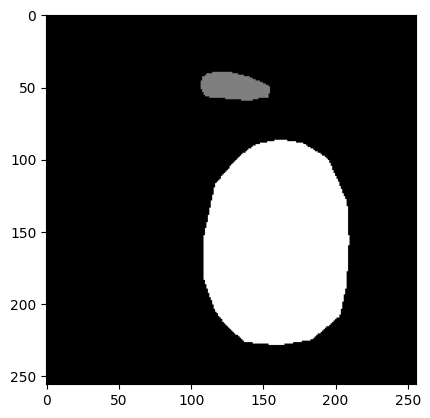

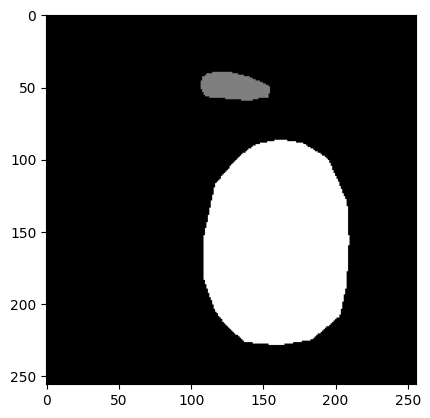

In [2]:
import cv2
import matplotlib.pyplot as plt
mask1 = cv2.imread("/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/00006_PSFHAoP4k_mask.png",0)

mask = cv2.imread("/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/00006_PSFHAoP4k_mask.png",0)  
mask_contour= cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)       #  detects boundaries
mask_img = cv2.drawContours(mask,mask_contour[0],0,255, -1)      # draws boundary on an image


img = cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB)
# Show the image
plt.imshow(img)
plt.show()

img1 = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [3]:
def pad_image_to_square(img):
    if img.dim() == 3:  # For tensors with channels: [C, H, W]
        channels, height, width = img.shape
    elif img.dim() == 2:  # For tensors without channels: [H, W]
        height, width = img.shape
        channels = None
    else:
        raise ValueError("Input tensor must be 2D or 3D")

    # Calculate padding
    if height > width:
        pad_size = (height - width) // 2
        padding = (pad_size, height - width - pad_size, 0, 0)  # Left, right, top, bottom
    elif width > height:
        pad_size = (width - height) // 2
        padding = (0, 0, pad_size, width - height - pad_size)  # Left, right, top, bottom
    else:
        return img  # Already square, no padding needed

    # Apply padding
    padded_img = torch.nn.functional.pad(img.unsqueeze(0), padding, mode="constant", value=0).squeeze(0)
    if channels:
        return padded_img
    else:
        return padded_img.squeeze(0)  # Remove channel dimension if it was 2D

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import os
import pandas as pd
from torchvision.io import read_image
import torch.utils.data as data

class CustomDataset(Dataset):
    def __init__(self, img_path, target_path, transform, target_transform):
        self.img_path = img_path 
        self.target_path = target_path
        self.transform = transform
        self.target_transform = target_transform

        # Define the mapping of pixel values to class labels
        self.class_mapping = {0: 0, 76: 1, 127: 1, 149: 2, 255: 2}  # Adjust based on your dataset

    def __len__(self):
        return len(os.listdir(self.img_path))

    def __getitem__(self, index):
        # Load and process the image
        img_path = os.path.join(self.img_path, sorted(os.listdir(self.img_path))[index])
        img = read_image(img_path)
        img_name = os.path.basename(img_path)
        img = pad_image_to_square(img)
        img = img.float() / 255.0
        

        # Load and process the target mask
        if self.target_path:
            mask_path = os.path.join(self.target_path, sorted(os.listdir(self.target_path))[index])
            mask_name = os.path.basename(mask_path)
            target = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            target = torch.from_numpy(target).long()  # Convert to long tensor
            target = pad_image_to_square(target)

            # Apply mapping to convert pixel values to class labels
            for key, value in self.class_mapping.items():
                target[target == key] = value

            # print(f"Remapped unique values in mask: {torch.unique(target)}")  # Debugging remapped values

            if self.target_transform and len(target.size()) > 1:
                target = self.target_transform(target.unsqueeze(0)).squeeze(0)
        else:
            target = torch.tensor([])

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        return img.float(), target,  img_name, mask_name

# Define the transformation to resize the images to a fixed size
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Use nearest interpolation to preserve class labels in the target masks
transform1 = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.NEAREST),
])

# Instantiate dataset objects
dataset = CustomDataset(
    img_path='/kaggle/input/unetdata/denoised_Standard_plane/Standard_plane',
    target_path='/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks',
    transform=transform,
    target_transform=transform1
)

test_dataset = CustomDataset(
    img_path='/kaggle/input/unetdata/TN_images/TN_images',
    target_path='/kaggle/input/unetdata/test_Masks/test_Masks',
    transform=transform,
    target_transform=transform1
)

# Check the number of images
img_path = '/kaggle/input/unetdata/denoised_Standard_plane/Standard_plane'
print(len(os.listdir(img_path)))

target_path = '/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks'
print(len(os.listdir(target_path)))

test_img_path = '/kaggle/input/unetdata/TN_images/TN_images'
print(len(os.listdir(test_img_path)))

test_target_path = '/kaggle/input/unetdata/test_Masks/test_Masks'
print(len(os.listdir(test_target_path)))

# Split the dataset into training and validation sets
# train_dataset, val_dataset = data.random_split(dataset, [6067, 1517], generator=torch.Generator().manual_seed(42))

# Create train and validation dataloaders
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

7584
7584
1414
1414


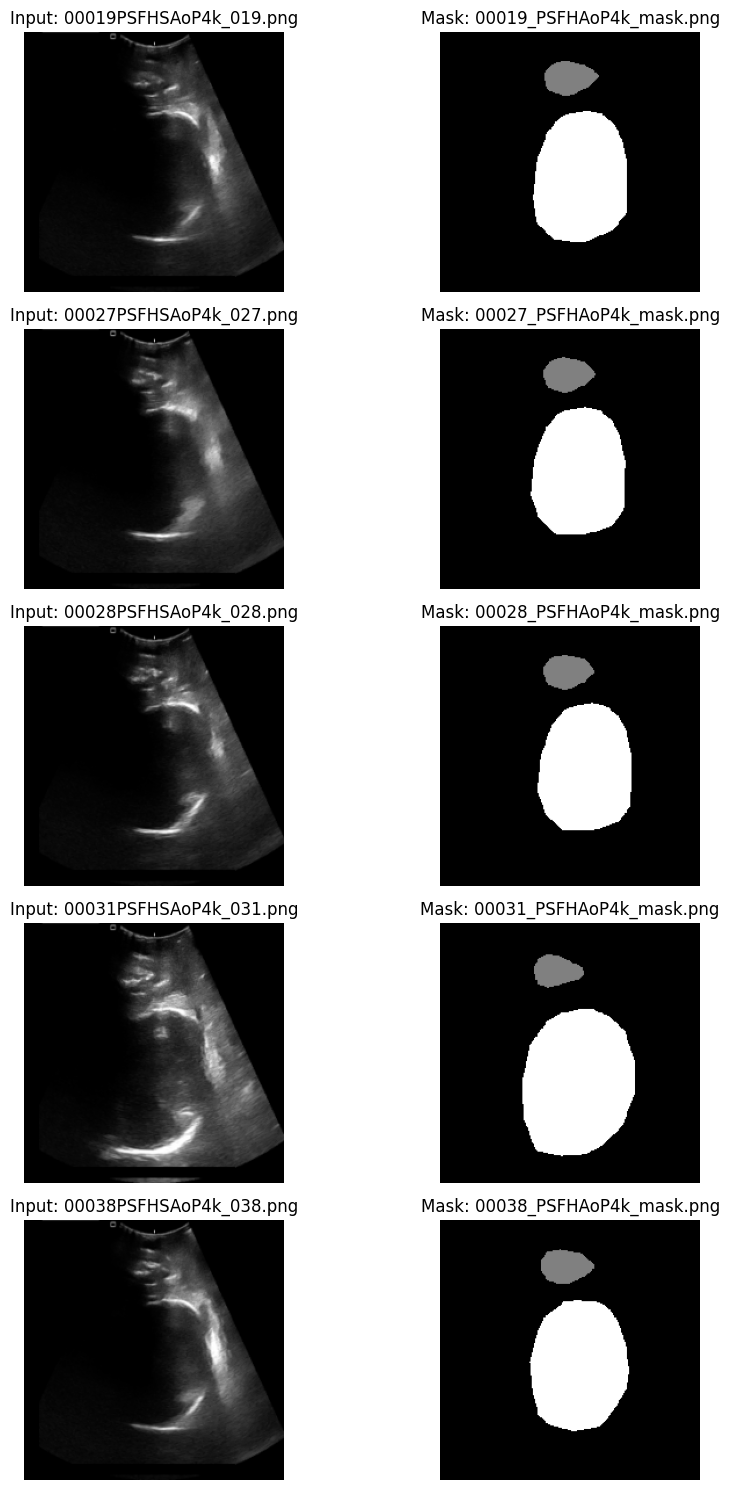

In [5]:
import matplotlib.pyplot as plt
import torch


# Get one batch of data
for i, batch in enumerate(test_dataloader):
    if i == 1:
        break  # Only take the first batch

    # Unpack batch
    images, masks, img_names, mask_names = batch  # images: (batch_size, C, H, W), masks: (batch_size, H, W)

    num_images = min(5, images.shape[0])  # Show up to 5 images

    # Create a figure with 5 rows and 2 columns
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images * 3))

    for j in range(num_images):
        # Original Image (Column 1)
        axs[j, 0].imshow(images[j, 0].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 0].set_title(f"Input: {img_names[j]}")
        axs[j, 0].axis('off')

        # Corresponding Mask (Column 2)
        axs[j, 1].imshow(masks[j].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 1].set_title(f"Mask: {mask_names[j]}")
        axs[j, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
from torch import nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import warnings
warnings.filterwarnings("ignore")


# ------------------------- ECA Implementation -------------------------

class eca_layer(nn.Module):
    """Constructs a ECA module.

    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)




# class BottleNeckConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(BottleNeckConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels*2, 3, 1, 1),
#             nn.BatchNorm2d(out_channels*2),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.conv(x)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNETDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNETDecoderBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2
        )

        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip_connection):
        # print(f"x shape: {x.shape}")
        x = self.upsample(x)
        # print(f"x after shape: {x.shape}")
        # print(f"skip_connection shape: {skip_connection.shape}")

        # Resize if necessary
        if x.shape != skip_connection.shape:
            x = TF.resize(x, size=skip_connection.shape[2:])
            # print(f"x later shape: {x.shape}")

        x = torch.cat((skip_connection, x), dim=1)
        # print(f"concatenation: {x.shape}")
        x = self.double_conv(x)
        # print(f"double conv: {x.shape}")
        return x




class Block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.identity_downsample = identity_downsample
        # print("identity:::",self.identity_downsample)

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class RAUNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(RAUNet, self).__init__()

        # Encoder
        self.in_channels = 64
        self.num_classes = num_classes
        self.firstconv = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.firstbn = nn.BatchNorm2d(64)
        self.firstrelu = nn.ReLU()
        self.firstmaxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.encoder1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.encoder2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.encoder3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.encoder4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        filters=[64, 128, 256, 512]
        self.bottleneck = DoubleConv(filters[-1], filters[-1]*2)

        # Decoder
        self.decoder4 = UNETDecoderBlock(filters[3]*2, filters[3])
        self.decoder3 = UNETDecoderBlock(filters[2]*2, filters[2])
        self.decoder2 = UNETDecoderBlock(filters[1]*2, filters[1])
        self.decoder1 = UNETDecoderBlock(filters[0]*2, filters[0])

        # self.gau3 = AAM(filters[2], filters[2]) #RAUNet
        # self.gau2 = AAM(filters[1], filters[1])
        # self.gau1 = AAM(filters[0], filters[0])
        self.eca4 = eca_layer(filters[3])
        self.eca3 = eca_layer(filters[2])
        self.eca2 = eca_layer(filters[1])
        self.eca1 = eca_layer(filters[0])


        # Final Classifier
        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], filters[0], 3, stride=2)
        self.finalrelu1 = nn.ReLU(inplace=True)
        self.finalconv2 = nn.Conv2d(filters[0], filters[0], 3)
        self.finalrelu2 = nn.ReLU(inplace=True)
        self.finalconv3 = nn.Conv2d(filters[0], num_classes, 2, padding=1)


    # noinspection PyCallingNonCallable
    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        # Encoder
        x = self.firstconv(x)
        # print(f"After firstconv: {x.shape}")
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        # print(f"After firstmaxpool: {x.shape}")

        e1 = self.encoder1(x)
        # print(f"Encoder 1 output: {e1.shape}")
        e2 = self.encoder2(e1)
        # print(f"Encoder 2 output: {e2.shape}")
        e3 = self.encoder3(e2)
        # print(f"Encoder 3 output: {e3.shape}")
        e4 = self.encoder4(e3)
        # print(f"Encoder 4 output: {e4.shape}")

        bot = self.bottleneck(e4)
        # print(f"Bottleneck output: {bot.shape}")

        cb4 = self.eca4(e4)
        # print("eca4: ",cb4.shape)
        d4 = self.decoder4(bot,cb4)
        # print(f"Decoder 4 output: {d4.shape}")
      
        cb3 = self.eca3(e3)
        # print("eca3: ",cb3.shape)
        d3 = self.decoder3(d4,cb3)
        # print(f"Decoder 3 output: {d3.shape}")
        
        cb2 = self.eca2(e2)
        # print("eca2: ",cb2.shape)
        d2 = self.decoder2(d3,cb2)
        # print(f"Decoder 2 output: {d2.shape}")

        cb1 = self.eca1(e1)
        # print("eca1: ",cb1.shape)
        d1 = self.decoder1(d2, cb1)
        # print(f"Decoder 1 output: {d1.shape}")

        # Final Classification
        f1 = self.finaldeconv1(d1)
        f1 = self.finaldeconv1(f1)
        # print(f"Final Deconv1 output: {f1.shape}")
        f2 = self.finalrelu1(f1)
        f3 = self.finalconv2(f2)
        f3 = self.finalconv2(f3)
        # print(f"Final Conv2 output: {f3.shape}")
        f4 = self.finalrelu2(f3)
        f5 = self.finalconv3(f4)
        # print(f"Final Conv3 output: {f5.shape}")

        if self.num_classes > 1:
            x_out = F.log_softmax(f5, dim=1)
        else:
            x_out = f5

        # print(f"Final Output: {x_out.shape}")
        return x_out


    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != intermediate_channels:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermediate_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(intermediate_channels)
            )
            
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [7]:
from torchsummary import summary
import torch

def RAUNet_eca():
    img_channel = 1
    num_classes = 3
    return RAUNet(Block, [3, 4, 6, 3], img_channel, num_classes)

model = RAUNet_eca()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)
print(model)

print(summary(model, input_size=(1, 224,224)))

cuda
RAUNet(
  (firstconv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU()
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(6

In [8]:
import torch
torch.cuda.empty_cache()  # Free up unused memory

In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [10]:
for batch in train_dataloader:
        inputs, targets, img_names, mask_names = batch
        print(f"Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
        print(f"Target unique values: {torch.unique(targets)}")
        break

Inputs shape: torch.Size([64, 1, 224, 224]), Targets shape: torch.Size([64, 224, 224])
Target unique values: tensor([0, 1, 2])


In [11]:
import copy


class EarlyStopping:
    def __init__(self, patience, min_delta=0.01, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None  # Initialize best_model to None
        self.best_loss = float('inf')  # Initialize best_loss to a large value
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        # Check if it's the first epoch or if validation loss improved
        if val_loss < self.best_loss:  # Use '<' to check for improvement
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    if self.best_model is not None:  # Check if best_model exists before loading
                        model.load_state_dict(self.best_model)
                    else:
                        print("Warning: No best model found to restore.")
                return True
        return False

In [12]:
def save_checkpoint(model, optimizer, path, epoch, early_stopping, all_train_loss, all_val_loss, all_train_dice,
                   all_val_dice,all_train_dice_wo, all_val_dice_wo, all_train_jaccard,all_val_jaccard, all_train_voe, all_val_voe, all_train_rvd,
                   all_val_rvd):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': early_stopping.best_loss,
        'counter': early_stopping.counter,
        'all_train_loss': all_train_loss,
        'all_val_loss': all_val_loss,
        'all_train_dice': all_train_dice,
        'all_val_dice': all_val_dice,
        'all_train_dice_wo': all_train_dice_wo,
        'all_val_dice_wo': all_val_dice_wo,
        'all_train_jaccard': all_train_jaccard,
        'all_val_jaccard': all_val_jaccard,
        'all_train_voe': all_train_voe,
        'all_val_voe': all_val_voe,
        'all_train_rvd': all_train_rvd,
        'all_val_rvd': all_val_rvd,
    }
    torch.save(checkpoint, path)


def save_best_model(model,path):
    checkpoint = {
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint,path)

In [13]:
# def match_dims_with_pred_mask(groundtruth_mask):
#   # print("Shape of groundtruth_mask before one-hot encoding:", groundtruth_mask.shape)

#   num_classes = 3
#   groundtruth_mask = np.eye(num_classes)[groundtruth_mask]  
#   # print("Shape after one-hot encoding (temporary):", groundtruth_mask.shape)

#   groundtruth_mask = np.moveaxis(groundtruth_mask, -1, 1)  
#   # print("Shape after axis reordering:", groundtruth_mask.shape)
#   return groundtruth_mask


# Dice score: Measures the overlap between the predicted and ground truth masks. A value of 1 indicates perfect overlap.
# The more the better
def dice_coef_without_class(pred_mask,groundtruth_mask):
    pred_mask = np.array(pred_mask)
    # print("pred_mask shape: ",pred_mask.shape)
    groundtruth_mask = np.array(groundtruth_mask)
    # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
    
    smooth = 0.0001
    intersect = np.sum(pred_mask*groundtruth_mask) + smooth
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask) + smooth
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 5)

def dice_coef(pred_masks, groundtruth_masks):
    
    pred_masks = np.array(pred_masks)
    # print("pred_masks shape: ",pred_masks.shape)
    groundtruth_masks = np.array(groundtruth_masks)
    # groundtruth_masks = match_dims_with_pred_mask(groundtruth_masks)

    smooth = 1e-6  # Smoothing value to avoid division by zero
    dice_per_class = []
    num_classes = 3

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        pred_class = (pred_masks == class_idx).astype(np.float32)
        groundtruth_class = (groundtruth_masks == class_idx).astype(np.float32)

        # Calculate Dice for the current class
        intersection = np.sum(pred_class * groundtruth_class, axis=(1, 2))  # Sum over spatial dimensions
        total_sum = np.sum(pred_class, axis=(1, 2)) + np.sum(groundtruth_class, axis=(1, 2))
        dice_class = (2. * intersection + smooth) / (total_sum + smooth)

        # Average Dice across the batch for this class
        dice_per_class.append(np.mean(dice_class))

    # Macro-average Dice (mean across all classes)
    mean_dice = np.mean(dice_per_class)
    return round(mean_dice, 5)

    # smooth = 0.001
    # dice_per_class = torch.zeros(3)
    # for class_id in range(3):
    #     y_pred_class = (pred_masks == class_id).float()
    #     y_true_class = (groundtruth_masks == class_id).float()

    #     intersection = torch.sum(y_pred_class*y_true_class)
    #     dice_per_class[class_id] = (2.0 * intersection + smooth) / (
    #         torch.sum(y_pred_class) + torch.sum(y_true_class)+smooth
    #     )

    # return dice_per_class



# Jaccard Index (IoU): Measures the intersection over the union of the predicted and ground truth masks.
# The more the better
def iou(pred_mask,groundtruth_mask):
    pred_mask = np.array(pred_mask)
    groundtruth_mask = np.array(groundtruth_mask)
    # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
 
    smooth = 0.0001
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = (intersect + smooth) / (union + smooth)  # Calculate per image IoU
    return round(np.mean(iou),5)  # Average IoU across all images in the batch


# Average Surface Distance (ASD): Measures the average distance between the boundary points of the predicted mask and the ground truth mask.
# The less the better


# Volume Overlap Error (VOE): For non-binary masks, VOE can be adapted by considering the sum of pixel values as a "soft overlap"
# Lower values are better.
def voe(pred_mask, gt_mask):
    pred_mask = np.array(pred_mask)
    gt_mask = np.array(gt_mask)
    # gt_mask = match_dims_with_pred_mask(gt_mask)

    smooth = 0.0001
    intersection = np.sum(np.minimum(pred_mask, gt_mask))  # Soft overlap
    union = np.sum(np.maximum(pred_mask, gt_mask))        # Soft union
    voe = 1 - ((intersection+smooth) / (union+smooth))
    return round(voe,5)


# Relative Volume Difference (RVD): RVD is particularly useful for applications where the total volume
# (e.g., of an organ or lesion) is more important than boundary alignment. It captures whether 
# the predicted segmentation overestimates or underestimates the actual volume.
# The range of Relative Volume Difference (RVD) is unbounded and can theoretically span from −∞ to +∞, depending 
# on the degree of overestimation or underestimation of the predicted volume compared to the ground truth volume. 

# Negative RVD (RVD<0):Indicates that the predicted volume is smaller than the ground truth.
# Example: RVD=−0.2 means the predicted volume is 20% smaller.

# Zero RVD (RVD=0): Indicates a perfect match between the predicted and ground truth volumes.

# Positive RVD (RVD>0): Indicates that the predicted volume is larger than the ground truth.
# Example: RVD=0.15 means the predicted volume is 15% larger.

# Lower values are better.

def rvd(pred_mask, gt_mask):
    pred_mask = np.array(pred_mask)
    gt_mask = np.array(gt_mask)
    # gt_mask = match_dims_with_pred_mask(gt_mask)

    smooth = 0.0001
    pred_volume = np.sum(pred_mask)  # Sum of intensities
    gt_volume = np.sum(gt_mask)     # Sum of intensities
    rvd = (pred_volume - gt_volume) / (gt_volume)
    return round(rvd,5)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from dataset import MyDataset
# from model import UNet

# torch.cuda.empty_cache()

import gc
# del inputs , targets , model
gc.collect()



# Define hyperparameters
learning_rate = 0.001
num_epochs = 200
patience = 20
early_stopping = EarlyStopping(patience=patience)
early_stop = False

k_folds = 5
batch_size = 16


def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set the seed globally
set_seed(42)


train_loaders = []
val_loaders = []
kf = KFold(n_splits=k_folds, shuffle=True)

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):

    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

    print(f"Fold {fold + 1}")
    print("-------")

    # for batch in train_loader:
    #     _, _, img_names, mask_names = batch
    #     print("Train Batch:", img_names)  

    # # Print image names for val_loader
    # print(f"Validation images in Fold {fold + 1}:")
    # for batch in val_loader:
    #     _, _, img_names, mask_names = batch
    #     print("Validation Batch:", img_names)
        
    print(f"Train_loader: {len(train_loaders[fold])}")
    print(f"Val_loader: {len(val_loaders[fold])}")

    if (fold+1) % 5 == 0:
        break

print(len(train_loaders))
print(len(val_loaders))



# Define the U-Net architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = RAUNet_eca().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


PATH = "/kaggle/working/checkpoint.pth"
outputCheckpoint_path = "/kaggle/outputs/checkpoint.pth"

load_PATH = "/kaggle/input/raunet_eca_tillepoch_150/pytorch/default/1/checkpoint.pth"

bestModel_path = "/kaggle/working/best_model.pth"
output_bestModel_path = "/kaggle/outputs/best_model.pth"


os.makedirs("/kaggle/working", exist_ok=True)
os.makedirs("/kaggle/outputs", exist_ok=True)

# import os
# print(f"File exists: {os.path.exists(load_PATH)}")
# print(f"File size: {os.path.getsize(load_PATH)} bytes")



if (os.path.exists(PATH) and os.path.getsize(PATH) > 0) or (os.path.exists(load_PATH) and os.path.getsize(load_PATH)>0):
    if os.path.exists(load_PATH):
        load_PATH = load_PATH
        print("input LOAD_PATH")
    else:
        load_PATH = PATH
        print("output path")
        
    # checkpoint = torch.load(load_PATH)
    # print(checkpoint['model_state_dict'].keys())
    checkpoint = torch.load(load_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    all_train_loss = checkpoint['all_train_loss']
    all_val_loss = checkpoint['all_val_loss']
    all_train_dice = checkpoint['all_train_dice']
    all_val_dice = checkpoint['all_val_dice']
    all_train_dice_wo = checkpoint['all_train_dice_wo']
    all_val_dice_wo = checkpoint['all_val_dice_wo']
    all_train_jaccard = checkpoint['all_train_jaccard']
    all_val_jaccard = checkpoint['all_val_jaccard']
    all_train_voe = checkpoint['all_train_voe']
    all_val_voe = checkpoint['all_val_voe']
    all_train_rvd = checkpoint['all_train_rvd']
    all_val_rvd = checkpoint['all_val_rvd']

    best_loss = checkpoint['best_loss']
    early_stopping.best_loss = best_loss
    counter = checkpoint['counter']
    early_stopping.counter = counter
    best_model_wts = model.state_dict()
    

    print("Checkpoint loaded successfully!")
    print("counter: ",counter)
    print("best_loss: ",best_loss)
    print("all_train_loss: ",all_train_loss)
    print("all_val_loss: ",all_val_loss)
    print("all train dice: ",all_train_dice)
    print("all val dice: ",all_val_dice)
    print("all train dice wo: ",all_train_dice_wo)
    print("all val dice wo: ",all_val_dice_wo)
    print("all train jaccard: ",all_train_jaccard)
    print("all val jaccard: ",all_val_jaccard)
    print('all train voe: ',all_train_voe)
    print('all val voe: ',all_val_voe)
    print('all train rvd: ',all_train_rvd)
    print('all val rvd: ',all_val_rvd)
    # print("model state dict:\n",model.load_state_dict(checkpoint['model_state_dict']).keys())
    start_epoch += 1
else:
    print("Checkpoint file is empty or missing. Initializing variables.")
    start_epoch = 0
    best_loss = 1e5
    best_model_wts = 0
    all_train_loss, all_val_loss = [], []
    all_train_dice, all_val_dice = [], []
    all_train_dice_wo, all_val_dice_wo = [], []
    all_train_jaccard, all_val_jaccard = [], []
    all_train_voe, all_val_voe = [], []
    all_train_rvd, all_val_rvd = [],[]



print("start_epoch: ",start_epoch)
# Train the U-Net
for epoch in range(start_epoch,num_epochs):
  print("-------epoch: ",epoch)

  fold = epoch % 5
  print("processing fold: ",fold)
  model.train()

#   train_loss = []
#   # train_dice = []
#   true = []
#   pre = []
#   data_iter = iter(train_loaders[fold])
#   inputs, targets, img_names, mask_names = next(data_iter)
#   # print(img_names)
#   # print(mask_names)
    
#   # Forward pass
#   inputs = inputs.to(device)   #
#   targets = targets.to(device)#

#   outputs = model(inputs)
#   loss = criterion(outputs, targets)

#   # Backward pass
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()

#   preds = torch.argmax(outputs, dim=1)

#   true.extend(targets.cpu().numpy())
#   pre.extend(preds.detach().cpu().numpy())

#   train_loss.append(loss.item()) 
# # train_dice.append(dice_score(preds, targets))


#   all_train_loss.append(np.mean(train_loss))
#   train_dice = dice_coef(pre,true)
#   all_train_dice.append(train_dice)
#   train_iou = iou(pre,true)
#   all_train_jaccard.append(train_iou)
#   train_voe = voe(pre,true)
#   all_train_voe.append(train_voe)
#   train_rvd = rvd(pre,true)
#   all_train_rvd.append(train_rvd)

#   print(f"Epoch [{epoch+1}/{num_epochs}], train Loss: {np.mean(train_loss):.4f}, train dice: {train_dice}, train jaccard: {train_iou}, train voe: {train_voe}, train rvd: {train_rvd}")


#   with torch.no_grad():
#     model.eval()
#     val_loss = []
#     val_true = []
#     val_pre = []
      
#     val_data_iter = iter(val_loaders[fold])
#     inputs, targets, img_names, mask_names = next(val_data_iter)

#     # print(img_names)
#     # print(mask_names)
        
#     inputs = inputs.to(device)
#     targets = targets.to(device)

#     outputs = model(inputs)
#     loss = criterion(outputs,targets)

#     preds = torch.argmax(outputs, dim=1)

#     val_true.extend(targets.cpu().numpy())
#     val_pre.extend(preds.detach().cpu().numpy())

#     val_loss.append(loss.item())
        
        
  
    
#   all_val_loss.append(np.mean(val_loss))
#   val_dice = dice_coef(val_pre,val_true)
#   all_val_dice.append(val_dice)
#   val_iou = iou(val_pre,val_true)
#   all_val_jaccard.append(val_iou)
#   val_voe = voe(val_pre,val_true)
#   all_val_voe.append(val_voe)
#   val_rvd = rvd(val_pre,val_true)
#   all_val_rvd.append(val_rvd)


#   if np.mean(val_loss) < best_loss:
#         # best_acc = val_accuracy
#         best_loss = np.mean(val_loss)
#         #Save the best model
#         best_model_wts = model.state_dict()
#         torch.save(best_model_wts, bestModel_path)
#         save_best_model(model,output_bestModel_path)
#         print(f"New best model saved with validation loss: {best_loss:.4f}")


#   optimizer.param_groups[0]['lr'] *= 0.9
#   early_stop = early_stopping(model, np.mean(val_loss))
#   print(early_stopping.status)

#   if early_stop:
#      print(f"Early stopping at epoch {epoch + 1}")
#      break
      
#   # Print the loss for the current epoch
#   print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {np.mean(val_loss):.4f}, val dice: {val_dice}, val jaccard: {val_iou}, val voe: {val_voe}, val rvd: {val_rvd}")

    
  train_loss = []
  # train_dice = []
  true = []
  pre = []
  # print("TRAINING:")
  for batch in train_loaders[fold]:
      inputs, targets, img_names, mask_names = batch
      # print("batch_id: ",batch_id)
      # print("each_batch_size: ",len(batch))
      # print(img_names)
      # print(mask_names)
    
      # Forward pass
      inputs = inputs.to(device)   #
      targets = targets.to(device)#

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      preds = torch.argmax(outputs, dim=1)

      true.extend(targets.cpu().numpy())
      pre.extend(preds.detach().cpu().numpy())

      train_loss.append(loss.item())
      # train_dice.append(dice_score(preds, targets))


  all_train_loss.append(np.mean(train_loss))
  train_dice = dice_coef(pre,true)
  all_train_dice.append(train_dice)
  train_dice_wo = dice_coef_without_class(pre,true)
  all_train_dice_wo.append(train_dice_wo)
  train_iou = iou(pre,true)
  all_train_jaccard.append(train_iou)
  train_voe = voe(pre,true)
  all_train_voe.append(train_voe)
  train_rvd = rvd(pre,true)
  all_train_rvd.append(train_rvd)

  print(f"Epoch [{epoch+1}/{num_epochs}], train Loss: {np.mean(train_loss):.4f}, train dice: {train_dice}, train_dice_wo: {train_dice_wo}, train jaccard: {train_iou}, train voe: {train_voe}, train rvd: {train_rvd}")

  # Evaluate the U-Net on the validation set
  with torch.no_grad():
    model.eval()
    val_loss = []
    val_true = []
    val_pre = []
    # print("VALIDATING")
      
    for batch in val_loaders[fold]:
        inputs, targets, img_names, mask_names = batch
        # print("batch_id: ",val_batch_id)
        # print("each_batch_size: ",len(batch))
        # val_batch_id+=1
        # print(img_names)
        # print(mask_names)
        
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs,targets)

        preds = torch.argmax(outputs, dim=1)

        val_true.extend(targets.cpu().numpy())
        val_pre.extend(preds.detach().cpu().numpy())

        val_loss.append(loss.item())
        
        
  
    
  all_val_loss.append(np.mean(val_loss))
  val_dice = dice_coef(val_pre,val_true)
  all_val_dice.append(val_dice)
  val_dice_wo = dice_coef_without_class(val_pre,val_true)
  all_val_dice_wo.append(val_dice_wo)
  val_iou = iou(val_pre,val_true)
  all_val_jaccard.append(val_iou)
  val_voe = voe(val_pre,val_true)
  all_val_voe.append(val_voe)
  val_rvd = rvd(val_pre,val_true)
  all_val_rvd.append(val_rvd)


  if np.mean(val_loss) < best_loss:
        # best_acc = val_accuracy
        best_loss = np.mean(val_loss)
        #Save the best model
        best_model_wts = model.state_dict()
        torch.save(best_model_wts, bestModel_path)
        save_best_model(model,output_bestModel_path)
        print(f"New best model saved with validation loss: {best_loss:.4f}")


  scheduler.step(np.mean(val_loss))
  early_stop = early_stopping(model, np.mean(val_loss))
  print(early_stopping.status)

  if early_stop:
     print(f"Early stopping at epoch {epoch + 1}")
     break
      
  # Print the loss for the current epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {np.mean(val_loss):.4f}, val dice: {val_dice}, val_dice_wo: {val_dice_wo}, val jaccard: {val_iou}, val voe: {val_voe}, val rvd: {val_rvd}")
    
  save_checkpoint(model, optimizer, PATH, epoch, early_stopping=early_stopping, all_train_loss=all_train_loss, all_val_loss=all_val_loss,
                  all_train_dice=all_train_dice, all_val_dice=all_val_dice, all_train_dice_wo = all_train_dice_wo, all_val_dice_wo = all_val_dice_wo,
                  all_train_jaccard=all_train_jaccard, all_val_jaccard=all_val_jaccard, all_train_voe=all_train_voe, all_val_voe=all_val_voe, 
                  all_train_rvd=all_train_rvd, all_val_rvd=all_val_rvd)
    
  save_checkpoint(model, optimizer, outputCheckpoint_path, epoch, early_stopping=early_stopping, all_train_loss=all_train_loss,all_val_loss=all_val_loss,
                 all_train_dice=all_train_dice, all_val_dice=all_val_dice, all_train_dice_wo = all_train_dice_wo, all_val_dice_wo = all_val_dice_wo,
                 all_train_jaccard=all_train_jaccard, all_val_jaccard=all_val_jaccard, all_train_voe=all_train_voe, all_val_voe=all_val_voe, 
                 all_train_rvd=all_train_rvd, all_val_rvd=all_val_rvd)
    
  print("checkpoint saved successfully")
  # torch.save(model.state_dict(),outputModel_path)

Fold 1
-------
Train_loader: 380
Val_loader: 95
Fold 2
-------
Train_loader: 380
Val_loader: 95
Fold 3
-------
Train_loader: 380
Val_loader: 95
Fold 4
-------
Train_loader: 380
Val_loader: 95
Fold 5
-------
Train_loader: 380
Val_loader: 95
5
5
cuda
input LOAD_PATH
Checkpoint loaded successfully!
counter:  0
best_loss:  0.002509971406604899
all_train_loss:  [0.140308248163446, 0.058953613650641945, 0.04704527520623646, 0.04257238974402609, 0.04006047200313524, 0.03677937940351273, 0.0350410245162876, 0.03283583104708477, 0.03172165574505925, 0.030862043351915322, 0.033695457924745584, 0.029901477929792905, 0.030387278651132395, 0.027300003575357168, 0.026513465692436223, 0.025802682457785858, 0.025216963524489027, 0.02421463799760922, 0.022878408177118552, 0.022326117685358776, 0.022439775486035568, 0.021526651459402944, 0.0204496757396938, 0.01998030100213854, 0.019720612490843784, 0.019046098863902062, 0.017941940070963218, 0.018936157792708592, 0.01787189878278265, 0.0165158310758047

Text(0, 0.5, 'loss')

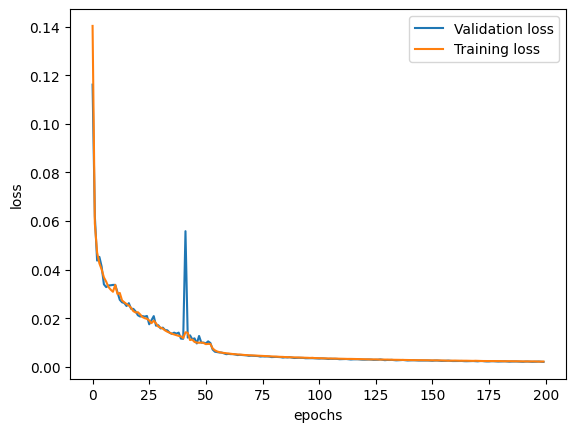

In [15]:
import matplotlib.pyplot as plt
plt.plot(all_val_loss)
plt.plot(all_train_loss)
plt.legend(["Validation loss" , "Training loss"])
plt.xlabel("epochs")
plt.ylabel("loss")

In [16]:
import os
import numpy as np
from PIL import Image

# From the best model

# model_weight_path = '/kaggle/input/raunet_eca_tillepoch_150/pytorch/default/1/best_model.pth'

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# model = RAUNet_eca().to(device)

# model.load_state_dict(torch.load(model_weight_path))
# print(model.load_state_dict(torch.load(model_weight_path)))

model.eval()


# Create an output directory for predicted masks
output_dir_work = "/kaggle/working/predicted_masks"
os.makedirs(output_dir_work, exist_ok=True)

output_dir = "/kaggle/outputs/predicted_images/"
os.makedirs(output_dir, exist_ok=True)

# Mapping dictionary
value_mapping = {0: 0, 1: 127, 2: 255}

with torch.no_grad():
    test_loss = []
    test_msk = []
    test_pred_msk = []
    test_img = []
    all_image_names = []
    all_mask_names = []
      
    for batch in test_dataloader:
        test_images, test_masks, img_names, mask_names = batch
        
        test_images = test_images.to(device)
        test_masks = test_masks.to(device)

        predicted_masks = model(test_images)
        predicted_masks = torch.argmax(predicted_masks, dim=1)

        # predicted_masks = model(test_images)
        # predicted_masks = torch.argmax(predicted_masks, dim=1).cpu().numpy().astype(np.uint8)

        test_img.extend(test_images.cpu().numpy())
        test_msk.extend(test_masks.cpu().numpy())
        test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

        all_image_names.extend(img_names)
        all_mask_names.extend(mask_names)

        # Save predicted masks as PNG images while keeping the original segmentation values (0,1,2)
        for i in range(predicted_masks.shape[0]):
            pred_mask = predicted_masks[i].cpu().numpy()  # Keep class values unchanged (0,1,2)
            # Apply the mapping: 0 → 0, 1 → 127, 2 → 255
            pred_mask = np.vectorize(value_mapping.get)(pred_mask).astype(np.uint8)
            # print(mask_names[i])
            pred_mask_img = Image.fromarray(pred_mask)  # No scaling, original values retained
            pred_mask_path = os.path.join(output_dir_work, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)
            pred_mask_path = os.path.join(output_dir, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)

print(f"Saved predicted masks in: {output_dir}")


    
    # batch = next(iter(test_dataloader))
    # test_images, test_masks, img_names, mask_names = batch
        
    # test_images = test_images.to(device)
    # test_masks = test_masks.to(device)

    # predicted_masks = model(test_images)
    # predicted_masks = torch.argmax(predicted_masks, dim=1)

    # test_img.extend(test_images.cpu().numpy())
    # test_msk.extend(test_masks.cpu().numpy())
    # test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

    # all_image_names.extend(img_names)
    # all_mask_names.extend(mask_names)
  
    
test_dice = dice_coef(test_pred_msk,test_msk)
test_dice_wo = dice_coef_without_class(test_pred_msk,test_msk)
test_iou = iou(test_pred_msk,test_msk)
test_voe = voe(test_pred_msk,test_msk)
test_rvd = rvd(test_pred_msk,test_msk)
      
# Print the loss for the current epoch
print(len(all_mask_names))
print(f"test dice: {test_dice:.4f}, test dice wo: {test_dice_wo}, test jaccard: {test_iou}, test voe: {test_voe}, test rvd: {test_rvd}")

Saved predicted masks in: /kaggle/outputs/predicted_images/
1414
test dice: 0.9598, test dice wo: 1.88934, test jaccard: 17.0737, test voe: 0.05497, test rvd: -0.00961


In [17]:
# after 80 epoch
# test dice: 0.9613, test dice wo: 1.88869, test jaccard: 16.96765, test voe: 0.05518, test rvd: -0.00816

# after 150 epoch
# test dice: 0.9595, test dice wo: 1.88827, test jaccard: 16.90037, test voe: 0.0559, test rvd: -0.00845

In [18]:
def relative_volume_difference(y_pred, y_true):
    rvd_list = []
    n_classes = 3
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the volumes (i.e., the sum of non-zero pixels)
        V_pred = torch.sum(y_pred_class)
        V_gt = torch.sum(y_true_class)
        
        # Calculate RVD for this class
        if V_gt != 0:
            rvd = torch.abs(V_pred - V_gt) / V_gt
        else:
            rvd = 0  # If the ground truth volume is zero, set RVD to zero (or some other default)
        
        rvd_list.append(rvd)
    
    # Return the mean RVD across all classes
    return torch.mean(torch.tensor(rvd_list))

# Volume Overlap Error (VOE) for multiclass segmentation
def volume_overlap_error(y_pred, y_true):
    voe_list = []
    n_classes = 3
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the intersection and union
        intersection = torch.sum(y_pred_class * y_true_class)
        union = torch.sum(torch.max(y_pred_class, y_true_class))
        
        # Calculate VOE for this class
        if union != 0:
            voe = (union - intersection) / union
        else:
            voe = 0  # If the union is zero, set VOE to zero (or some other default)
        
        voe_list.append(voe)
    
    # Return the mean VOE across all classes
    return torch.mean(torch.tensor(voe_list))

In [19]:
import torch
from torchmetrics import JaccardIndex, Dice

n_classes = 3

# IoU (Jaccard Index) metric
iou_metric = JaccardIndex(task="multiclass", num_classes=n_classes)

# Dice Score metric (also called F1 Score for segmentation)
dice_metric = Dice(num_classes=n_classes, average='macro')

# Convert ground truth and prediction to PyTorch tensors
y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)
y_pred_tensor = torch.tensor(test_pred_msk, dtype=torch.int64)   # (16, 224, 224)

# Ensure tensors are on the same device (important for GPUs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_test_tensor = y_test_tensor.to(device)
y_pred_tensor = y_pred_tensor.to(device)

iou_metric = iou_metric.to(device)
dice_metric = dice_metric.to(device)

# Compute IoU
mean_iou = iou_metric(y_pred_tensor, y_test_tensor)
print("Mean IoU =", mean_iou.item())

# Compute Dice Score
dice_score = dice_metric(y_pred_tensor, y_test_tensor)
print("Dice Score =", dice_score.item())

rvd = relative_volume_difference(y_pred_tensor, y_test_tensor)
print("Relative Volume Difference (RVD) =", rvd.item())

voe = volume_overlap_error(y_pred_tensor, y_test_tensor)
print("Volume Overlap Error (VOE) =", voe.item())


Mean IoU = 0.9356687068939209
Dice Score = 0.9660378098487854
Relative Volume Difference (RVD) = 0.008979355916380882
Volume Overlap Error (VOE) = 0.0643313080072403


In [20]:
# after 80 epoch
# Mean IoU = 0.9370909929275513
# Dice Score = 0.9668595194816589
# Relative Volume Difference (RVD) = 0.012512709014117718
# Volume Overlap Error (VOE) = 0.06290898472070694


# after 150 epoch
# Mean IoU = 0.9350136518478394
# Dice Score = 0.9656804800033569
# Relative Volume Difference (RVD) = 0.010511050932109356
# Volume Overlap Error (VOE) = 0.06498629599809647

1414
00019PSFHSAoP4k_019.png
00019_PSFHAoP4k_mask.png
00027PSFHSAoP4k_027.png
00027_PSFHAoP4k_mask.png
00028PSFHSAoP4k_028.png
00028_PSFHAoP4k_mask.png
00031PSFHSAoP4k_031.png
00031_PSFHAoP4k_mask.png
00038PSFHSAoP4k_038.png
00038_PSFHAoP4k_mask.png


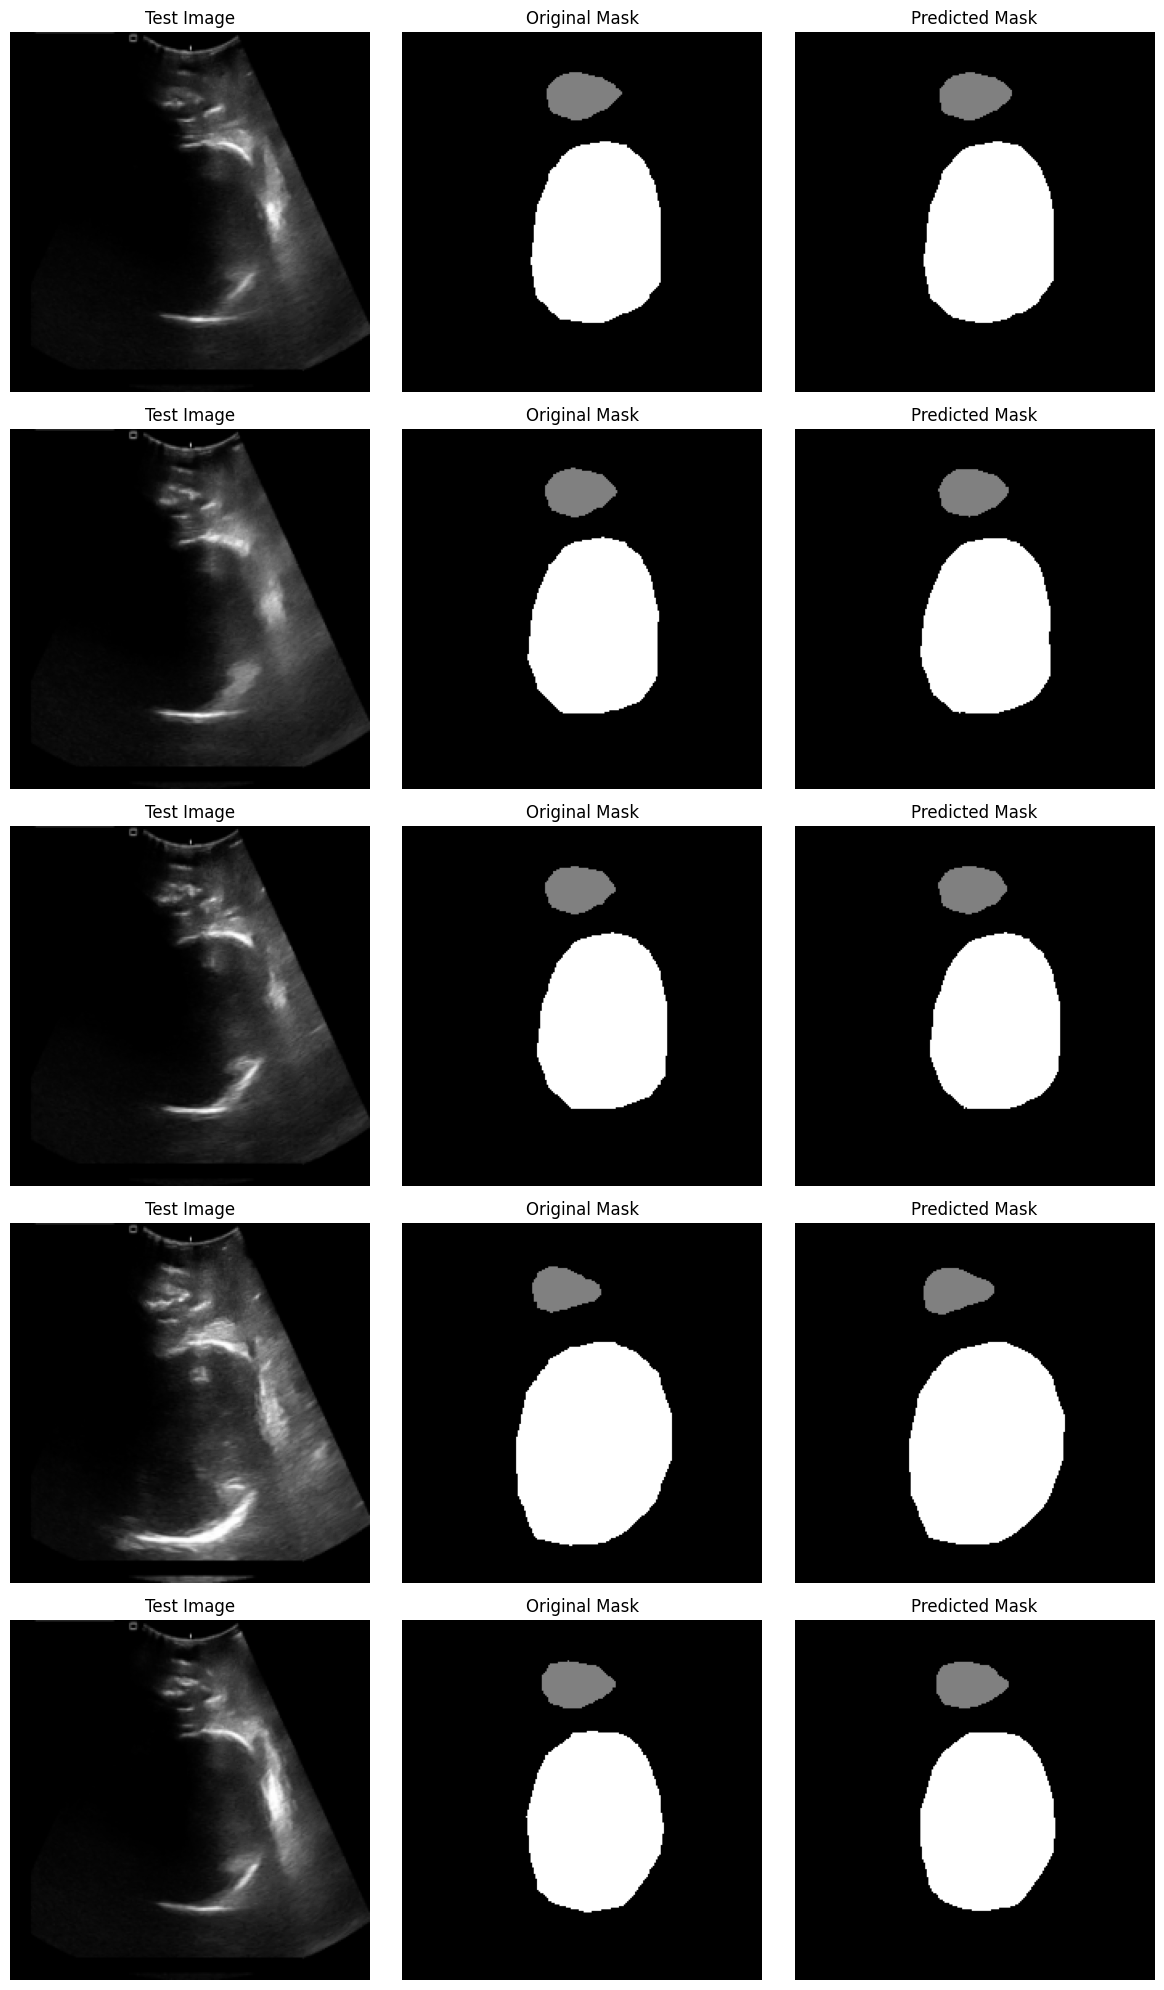

In [21]:
import cv2

test_img = np.array(test_img)
test_msk = np.array(test_msk)
test_pred_msk = np.array(test_pred_msk)

num_images = min(5, test_img.shape[0])  # Show up to 5 images
print(test_img.shape[0])

# Plot original image, ground truth mask, and predicted mask side by side
fig, axs = plt.subplots(nrows=num_images, ncols=3, figsize=(12, num_images * 4))

for i in range(num_images):
    print(all_image_names[i])
    print(all_mask_names[i])
    # Original Image
    axs[i, 0].imshow(test_img[i, 0], cmap='gray')  # Assuming grayscale images
    axs[i, 0].set_title("Test Image")
    axs[i, 0].axis("off")

    # Ground Truth Mask
    axs[i, 1].imshow(test_msk[i], cmap='gray')  # Ground truth masks with class labels
    axs[i, 1].set_title("Original Mask")
    axs[i, 1].axis("off")

    # Model-Predicted Mask
    axs[i, 2].imshow(test_pred_msk[i], cmap='gray')  # Predicted masks with class labels
    axs[i, 2].set_title("Predicted Mask")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()